<a href="https://colab.research.google.com/github/Pathway2008/enefit/blob/main/enefit_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!sudo apt install nvidia-driver-460 nvidia-cuda-toolkit clinfo
!apt-get update --fix-missing
!pip install -q  lightgbm==4.1.0 \
  --config-settings=cmake.define.USE_GPU=ON \
  --config-settings=cmake.define.OpenCL_INCLUDE_DIR="/usr/local/cuda/include/" \
  --config-settings=cmake.define.OpenCL_LIBRARY="/usr/local/cuda/lib64/libOpenCL.so"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
clinfo is already the newest version (3.0.21.02.21-1).
Some packages could not be installed. This may mean that you have
requested an impossible situation or if you are using the unstable
distribution that some required packages have not yet been created
or been moved out of Incoming.
The following information may help to resolve the situation:

The following packages have unmet dependencies:
 libnvidia-compute-510 : Depends: libnvidia-compute-525 but it is not installable
 nvidia-cuda-dev : Breaks: libcuda1 (< 495)
                   Recommends: libnvcuvid1 but it is not installable
E: Unable to correct problems, you have held broken packages.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]

In [34]:
pip install --upgrade lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import gc
import pickle

import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px

from sklearn.ensemble import VotingRegressor
import lightgbm as lgb

In [39]:
root = '/content/drive/MyDrive/kaggle/Enefit/'
train = pd.read_csv(root+'train.csv')
client = pd.read_csv(root+'client.csv')
electric = pd.read_csv('/content/drive/MyDrive/kaggle/Enefit/electricity_prices.csv')
forecast_weather = pd.read_csv('/content/drive/MyDrive/kaggle/Enefit/forecast_weather.csv')
gas_price = pd.read_csv(root+'gas_prices.csv')
hist_weather = pd.read_csv('/content/drive/MyDrive/kaggle/Enefit/historical_weather.csv')
mapping = pd.read_csv('/content/drive/MyDrive/kaggle/Enefit/weather_station_to_county_mapping.csv')

In [53]:
electric = pd.read_csv('/content/drive/MyDrive/kaggle/Enefit/electricity_prices.csv')
electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [18]:
train.isna().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [40]:
train = train.dropna(how='any')
train.isna().sum()

county                0
is_business           0
product_type          0
target                0
is_consumption        0
datetime              0
data_block_id         0
row_id                0
prediction_unit_id    0
dtype: int64

In [57]:
earliest_time = train['datetime'].min()
def extract_dt_attributes(df:pd.DataFrame):
    # convert datetime column, if not done already
    df['datetime'] = pd.to_datetime(df['datetime'])

    # dates and times
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.strftime('%H:%M:%S')

    #
    df['year'] = df['datetime'].dt.year
    df['datediff_in_days'] = (
        df['datetime']- earliest_time
    ).dt.days

    # dictionary with time features as keys
    # and min and max as values
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }

    for col in time_features:
        if col=='week':
            df[col] = df['datetime'].dt.isocalendar().week.astype(np.int32)
        else:
            df[col] = getattr(df['datetime'].dt,col)


        ## sin and cosine features to capture the circular continuity
        col_min,col_max = time_features[col]
        angles = 2*np.pi*(df[col]-col_min)/(col_max-col_min+1)

        # add sin and cos
        df[col+'_sine'] = np.sin(angles).astype('float')
        df[col+'_cosine'] = np.cos(angles).astype('float')

In [58]:
extract_dt_attributes(train)

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017824 entries, 0 to 2017823
Data columns (total 30 columns):
 #   Column               Dtype         
---  ------               -----         
 0   county               int64         
 1   is_business          int64         
 2   product_type         int64         
 3   target               float64       
 4   is_consumption       int64         
 5   datetime             datetime64[ns]
 6   data_block_id        int64         
 7   row_id               int64         
 8   prediction_unit_id   int64         
 9   date                 object        
 10  type                 object        
 11  eic_count            float64       
 12  installed_capacity   float64       
 13  consumption_per_eic  float64       
 14  production_rate      float64       
 15  time                 object        
 16  year                 int64         
 17  datediff_in_days     int64         
 18  hour                 int64         
 19  hour_sine            

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

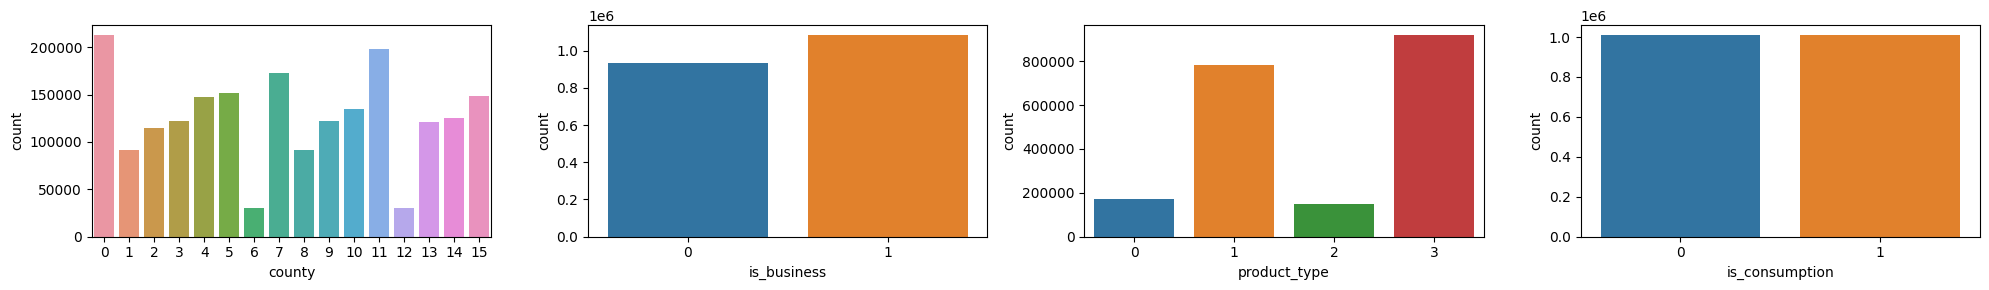

In [27]:
desc_columns = ['county','is_business','product_type','is_consumption']

fig, axs = plt.subplots(1, len(desc_columns), figsize=(5*len(desc_columns), 3))

for i, column in enumerate(desc_columns):
    _ = sns.countplot(train, x=column, ax=axs[i])

_ = fig.tight_layout()

In [41]:
train['datetime'] = pd.to_datetime(train['datetime'])

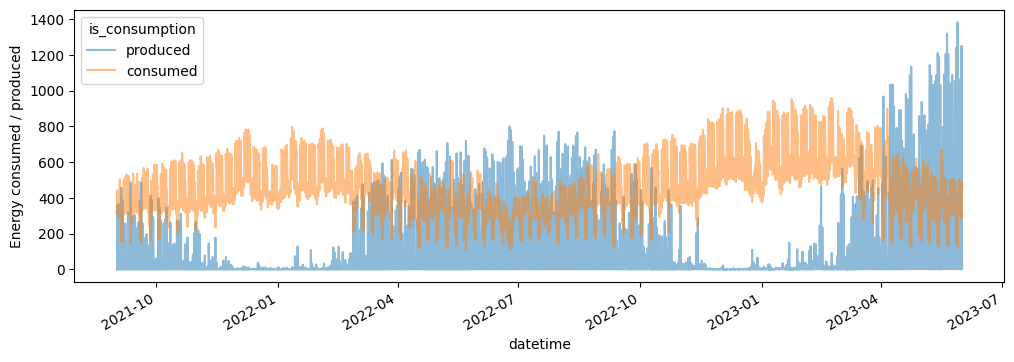

In [31]:
train_avgd = (
    train
    .groupby(['datetime','is_consumption'])
    ['target'].mean()
    .unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')

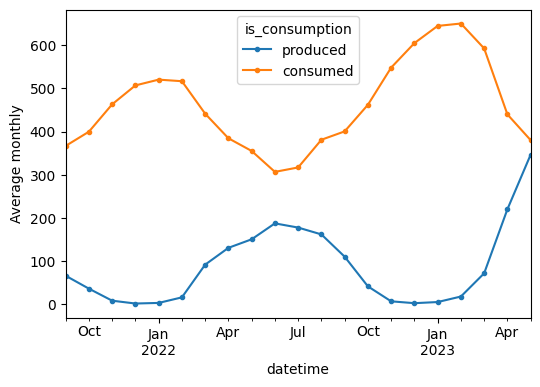

In [32]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
_ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Average monthly')

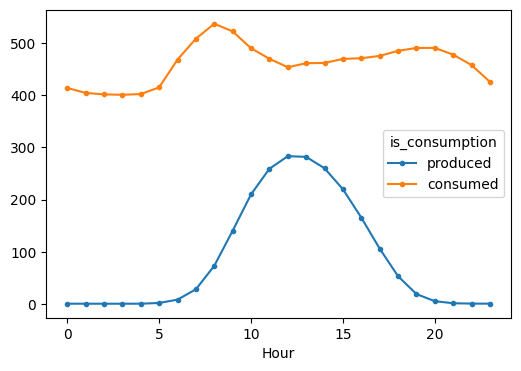

In [33]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')

In [54]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

In [55]:
# Data manipulation
electric.loc[electric['euros_per_mwh'] == 4000, 'euros_per_mwh'] = 750.08
electric_daily = electric.copy()
electric_daily['forecast_date'] = pd.to_datetime(electric_daily['forecast_date'])

electric_daily['date'] = electric_daily['forecast_date'].dt.date
electric_daily = electric_daily.groupby('date').agg({'euros_per_mwh': 'mean'}).reset_index()

gas_prices_longer = pd.melt(gas_price, id_vars=['forecast_date'], value_vars=['lowest_price_per_mwh', 'highest_price_per_mwh'], var_name='type', value_name='price_per_mwh')

# Create subplots
fig = make_subplots(rows=2, cols=1)

# Add line plot for electricity prices
fig.add_trace(
    go.Scatter(
        x=electric['forecast_date'],
        y=electric['euros_per_mwh'],
        mode='lines',
        name='Electricity Prices',
        line=dict(color='gray')
    ),
    row=1,
    col=1
)

# Add line plot for daily average of electricity prices
fig.add_trace(
    go.Scatter(
        x=electric_daily['date'],
        y=electric_daily['euros_per_mwh'],
        mode='lines',
        name='Daily Average',
        line=dict(color='purple')
    ),
    row=1,
    col=1
)

# Add line plot for gas prices
for t in gas_prices_longer['type'].unique():
    fig.add_trace(
        go.Scatter(
            x=gas_prices_longer[gas_prices_longer['type'] == t]['forecast_date'],
            y=gas_prices_longer[gas_prices_longer['type'] == t]['price_per_mwh'],
            mode='lines',
            name=t
        ),
        row=2,
        col=1
    )

# Update layout
fig.update_layout(
    title='Electricity and Gas Prices',
    xaxis_title='',
    yaxis_title='',
    legend_title_text='Type',
    legend=dict(y=1, yanchor='bottom', x=0.5, xanchor='center'),
    height=800  # Adjust the height of the figure
)

fig.show()

In [56]:
train['date'] = pd.to_datetime(train['datetime']).dt.date
train['type'] = ['CONSUME' if x == 1 else 'PRODUCE' for x in train['is_consumption']]
train = pd.merge(train, client.drop(columns='data_block_id'), on=['county', 'is_business', 'product_type', 'date'], how='left')
train['consumption_per_eic'] = train['target'] / train['eic_count']
train['production_rate'] = train['target'] / train['installed_capacity']

period_min = train['datetime'].min()
period_max = train['datetime'].max()

def target_plot(unit_id, period_min=period_min, period_max=period_max):
    df = train[(train['prediction_unit_id']==unit_id) & (train['datetime']>=period_min) & (train['datetime']<=period_max)]
    county_ = df.iloc[0]['county']
    product_ = df.iloc[0]['product_type']
    business_ = df.iloc[0]['is_business']

    # Create subplots
    fig = make_subplots(rows=1, cols=1)

    # Add line plot for target values
    for t in df['type'].unique():
        fig.add_trace(
            go.Scatter(
                x=df[df['type'] == t]['datetime'],
                y=df[df['type'] == t]['target'],
                mode='lines',
                name=t
            )
        )

    # Add line plot for installed capacity
    fig.add_trace(
        go.Scatter(
            x=df[df['is_consumption'] == 1].dropna()['date'],
            y=df[df['is_consumption'] == 1].dropna()['installed_capacity'],
            mode='lines',
            name='Installed Capacity',
            line=dict(color='darkgray')
        )
    )

    # Update layout
    fig.update_layout(
        title=f'Target Values of Unit {unit_id} (County {county_}, Product Type {product_}, Business {business_})',
        xaxis_title='',
        yaxis_title='',
        legend_title_text='Type',
        legend=dict(y=1, yanchor='bottom', x=0.5, xanchor='center'),
    )

    fig.show()

# Plot for unit IDs from 0 to 4
for id in range(5):
    target_plot(id)

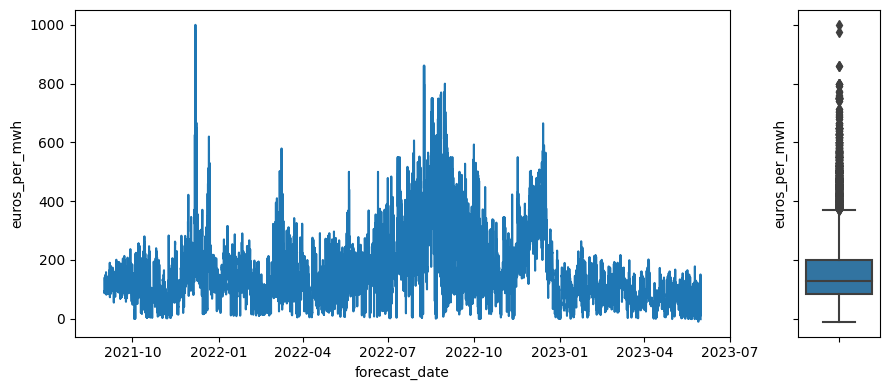

In [63]:
electric['forecast_date'] = pd.to_datetime(electric['forecast_date'])
electric['time'] = electric['forecast_date'].dt.strftime('%H:%M:%S')

fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(electric, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(electric, y='euros_per_mwh', ax=axs[1])
#_ = axs[1].get_yaxis().set_visible(False)
fig.tight_layout()

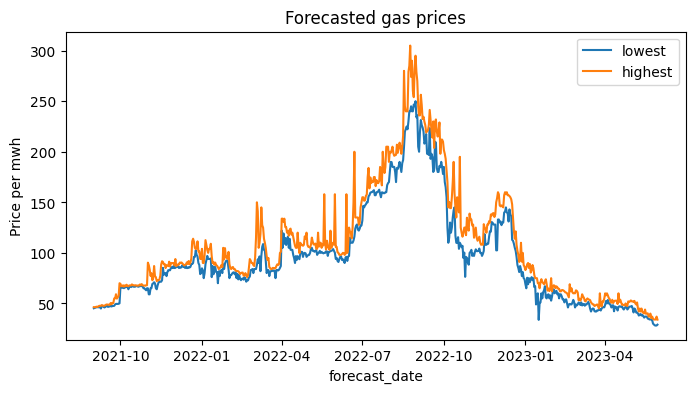

In [64]:
gas_price['forecast_date'] = pd.to_datetime(gas_price['forecast_date'])
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
_ = sns.lineplot(gas_price, x='forecast_date', y='lowest_price_per_mwh', ax=ax, label='lowest')
_ = sns.lineplot(gas_price, x='forecast_date', y='highest_price_per_mwh', ax=ax, label='highest')
_ = ax.legend()
_ = ax.set_ylabel('Price per mwh')
_ = ax.set_title('Forecasted gas prices')

In [2]:
class DataStorage:
    root = "/content/drive/MyDrive/kaggle/Enefit"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test

In [3]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.groupby("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .groupby("county", "datetime")
            .mean()
        )

        for hours_lag in [7 * 24 , 0]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.groupby("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .groupby("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.groupby(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.groupby(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

In [4]:
class Model:
    def __init__(self):
        self.model_parameters = {
            "n_estimators": 2500,
            "learning_rate": 0.06,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 15,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            "device": "gpu"
        }

        self.model_consumption = VotingRegressor(
            [
                (
                    f"consumption_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i),
                )
                for i in range(10)
            ]
        )
        self.model_production = VotingRegressor(
            [
                (
                    f"production_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i),
                )
                for i in range(10)
            ]
        )

    def fit(self, df_train_features):
        mask = df_train_features["is_consumption"] == 1
        self.model_consumption.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
        )

        mask = df_train_features["is_consumption"] == 0
        self.model_production.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
        )

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = self.model_consumption.predict(
            df_features[mask]
        ).clip(0)

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = self.model_production.predict(
            df_features[mask]
        ).clip(0)

        return predictions

In [5]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)

In [6]:
df_train_features = features_generator.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]

In [7]:
import holidays
import datetime

estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
estonian_holidays = list(estonian_holidays.keys())

def add_holidays_as_binary_features(df):
    df['country_holiday'] = df.apply(lambda row: (datetime.date(row['year'], row['month'], row['day']) in estonian_holidays) * 1, axis=1)

    return df

df_train_features = add_holidays_as_binary_features(df_train_features)

In [32]:
df_train_features.columns[0:50]

Index(['county', 'is_business', 'product_type', 'is_consumption', 'day',
       'weekday', 'month', 'year', 'segment', 'sin(dayofyear)',
       'cos(dayofyear)', 'sin(hour)', 'cos(hour)', 'eic_count',
       'installed_capacity', 'temperature', 'dewpoint', 'cloudcover_high',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation', 'temperature_forecast_local_168h',
       'dewpoint_forecast_local_168h', 'cloudcover_high_forecast_local_168h',
       'cloudcover_low_forecast_local_168h',
       'cloudcover_mid_forecast_local_168h',
       'cloudcover_total_forecast_local_168h',
       '10_metre_u_wind_component_forecast_local_168h',
       '10_metre_v_wind_component_forecast_local_168h',
       'direct_solar_radiation_forecast_local_168h',
       'surface_solar_radiation_downwards_forecast_local_168h',
     

In [8]:
model = Model()
model.fit(df_train_features)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 38787
[LightGBM] [Info] Number of data points in the train set: 825951, number of used features: 164


LightGBMError: No OpenCL device found